In [1]:
from CUKG import CUKG
import opinion_dataset as random_dataset

import pandas as pd
import numpy as np

import tools
import matplotlib.pyplot as plt
import pickle

In [2]:
def run_experiment(df, classifier):
    if type(classifier).__name__ == 'CUKG' or type(classifier).__name__ == 'History':
        opinions, confidence = tools.dataframe_to_opinions(df)
        aggregated_labels = classifier.run(confidence, opinions)
    elif type(classifier).__name__ == 'DTWMV':
        opinions, confidence = tools.dataframe_to_opinions(df)
        aggregated_labels = classifier.run(confidence)
    else:
        aggregated_labels = classifier.fit_predict(df)
        
    return aggregated_labels

In [3]:
def print_variables(classifiers, prob_type_workers, n_tasks,n_workers,percetage_tasks_workers,prob_worker,
                    confidence_worker,hard_labels,itt):
    print("classifiers: ",classifiers)
    print("prob_type_workers: ",prob_type_workers)
    print("n_tasks: ",n_tasks)
    print("n_workers: ",n_workers)
    print("percetage_tasks_workers: ",percetage_tasks_workers)
    print("prob_worker: ",prob_worker)
    print("confidence_worker: ",confidence_worker)
    print("hard_labels: ",hard_labels)
    print("itt: ",itt)
    return

In [4]:
def save_variables(save_file, classifiers, prob_type_workers, n_tasks,n_workers,percetage_tasks_workers,prob_worker,
                    confidence_worker,hard_labels,itt):
    with open(save_file+"n_workers_variables.txt", "w") as file:
        file.write("classifiers: " + str(classifiers) + "\n")
        file.write("prob_type_workers: " + str(prob_type_workers) + "n")
        file.write("n_tasks: " + str(n_tasks) + "\n")
        file.write("n_workers: " + str(n_workers) + "\n")
        file.write("percetage_tasks_workers: " + str(percetage_tasks_workers) + "\n")
        file.write("prob_worker: " + str(prob_worker) + "\n")
        file.write("confidence_worker: " + str(confidence_worker) + "\n")
        file.write("hard_labels: " + str(hard_labels) + "\n")
        file.write("itt: " + str(itt) + "\n")
    return

In [5]:
def save_results(save_file,final_responses, final_labels, final_accuracies, final_errors):
    results = [save_file,final_responses, final_labels, final_accuracies, final_errors]
    with open(save_file+'n_workers_results.pickle', 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return

In [6]:
#prob_worker = ([[type_worker_x0,type_worker_x1,...] , [type_worker_y0,type_worker_y1,...], ...] -> experiments x, y...
def run_experiment_random_datasets(classifier, prob_type_worker, n_tasks,n_workers,percetage_tasks_workers=1,
                                   prob_worker=[[0.3,0.1],[0.3,0.1],[0.8,0.1],[0.8,0.1],[-1,-1],[-1,-1],[-1,-1]],
                                   confidence_worker=[[0.8,0.1],[0.3,0.1],[0.8,0.1],[0.3,0.1],[-1,0.1],[-1,-1],[0.8,0.1]],hard_labels=False, itt=30, save_file="./"):

    print_variables(classifier, prob_type_workers, n_tasks,n_workers,percetage_tasks_workers,prob_worker,confidence_worker,hard_labels,itt)
    save_variables(save_file, classifier, prob_type_workers, n_tasks,n_workers,percetage_tasks_workers,prob_worker,confidence_worker,hard_labels,itt)
    

    final_accuracies = []
    final_errors = []
    final_labels = []
    final_responses = []
    for count1, tasks in enumerate(n_tasks):
        accuracies = []
        errors = []
        labels = []
        responses = []
        for count2, workers in enumerate(n_workers):
            accuracy = []
            error = []
            label = []
            response = []
            for i in range(itt):
                lbls, workers_opinions, confidence_opinions, probabilities = random_dataset.generate_dataset(tasks,workers,percetage_tasks_workers,
                                                                                                               prob_type_worker,prob_worker,confidence_worker,hard_labels)
                df = tools.opinions_to_dataframe(workers_opinions, confidence_opinions, bin_lenght = -1)
                df_digitize = tools.opinions_to_dataframe(workers_opinions, confidence_opinions)
                accs = []
                errs = []
                res = []

                if type(classifier).__name__ == 'CUKG' or type(c).__name__ == 'DTWMV' or type(classifier).__name__ == 'History':
                    r = run_experiment(df, classifier)
                else:
                    r = run_experiment(df_digitize, classifier)
                    r = tools.reverse_digitize_features(r)

                acc = tools.calculate_accuracy(lbls, r)
                err = tools.calculate_avg_error(lbls, r)

                accuracy.append(acc)
                error.append(err)
                response.append(r)
                labels.append(lbls)
                
                total = itt*len(n_workers)*len(n_tasks)
                percentage = ((i +  (count2*itt) + (count1*len(n_workers)*itt))/ total)*100
                print(f"\rProgress: {percentage:.2f}%", end="")
                
            responses.append(response)
            labels.append(label)
            accuracies.append(accuracy)
            errors.append(error)
            
        final_responses.append(responses)
        final_labels.append(labels)
        final_accuracies.append(accuracies)
        final_errors.append(errors)

    save_results(save_file,final_responses, final_labels, final_accuracies, final_errors)

    return final_responses, final_labels, final_accuracies, final_errors

In [7]:
def plot_experiment(data_points, x_label, y_label, labels=['5 tasks', '10 tasks', '20 tasks', '40 tasks', '80 tasks'], title="", 
                    custom_x_labels=['5', '10', '20', '40', '80', '160', '320', '640'],
                    colors=['blue', 'cyan', 'red', 'pink', 'green', 'black', 'purple', 'orange', 'yellow'], save_file="./"):

    #Take average of the all iterations
    averages = np.mean(data_points, axis=2)

    custom_x=[5, 10, 20, 40, 80, 160, 320,640]
    custom_x = custom_x[:len(averages[0])]
    fig, ax = plt.subplots(figsize=(12, 6))  # Make sure `ax` is used here
    #Plot lines
    for i in range(len(labels)):
        ax.plot(custom_x, averages[i], label=labels[i], marker='o')
        #plt.plot(custom_x, averages[:, i], label=labels[i], marker='o')

    ax.set_xscale('log', base=2)

    # Adding labels and title
    ax.set_xlabel(x_label, fontsize=28)
    ax.set_ylabel(y_label, fontsize=28)
    # Increase the font size for tick labels
    ax.tick_params(axis='both', which='major', labelsize=28)  # 'both' affects both x and y axes
    
    if title != "":
        ax.set_title(title)
    plt.legend(fontsize=28)

    #Custom x-axis labels
    if custom_x_labels != "":
        ax.set_xticks(custom_x)
        ax.set_xticklabels(custom_x_labels, rotation=45, ha="right")  # Rotate x-axis tick labels 45 degrees for readability

    #save
    plt.savefig(save_file+"n_workers-"+y_label+".pdf",bbox_inches='tight')
    
    # Show the plot
    plt.show()

In [8]:
cukg = CUKG()

In [9]:
prob_type_workers = [0,0,0,0,1,0,0] #realistic workers

In [10]:
n_tasks = [5,10,20,40,80]
n_workers = [5,10,20,40,80,160,320,640]

In [11]:
save_file = "/home/su_dalle-lucca-tosi/Jupyter_notebooks/CrowdSource/n_workers/"

In [12]:
result = run_experiment_random_datasets(cukg, prob_type_workers, n_tasks, n_workers, save_file=save_file)

classifiers:  <CCKG.CCKG object at 0x7064487238d0>
prob_type_workers:  [0, 0, 0, 0, 1, 0, 0]
n_tasks:  [5, 10, 20, 40, 80]
n_workers:  [5, 10, 20, 40, 80, 160, 320, 640]
percetage_tasks_workers:  1
prob_worker:  [[0.3, 0.1], [0.3, 0.1], [0.8, 0.1], [0.8, 0.1], [-1, -1], [-1, -1], [-1, -1]]
confidence_worker:  [[0.8, 0.1], [0.3, 0.1], [0.8, 0.1], [0.3, 0.1], [-1, 0.1], [-1, -1], [0.8, 0.1]]
hard_labels:  False
itt:  30
Progress: 99.92%

In [13]:
final_responses, final_labels, final_accuracies, final_errors = result

In [14]:
'''
with open(save_file+ 'n_workers_results.pickle', 'rb') as handle:
    result = pickle.load(handle)

final_responses, final_labels, final_accuracies, final_errors = result
'''

"\nwith open(save_file+ 'n_workers_results.pickle', 'rb') as handle:\n    result = pickle.load(handle)\n\nfinal_responses, final_labels, final_accuracies, final_errors = result\n"

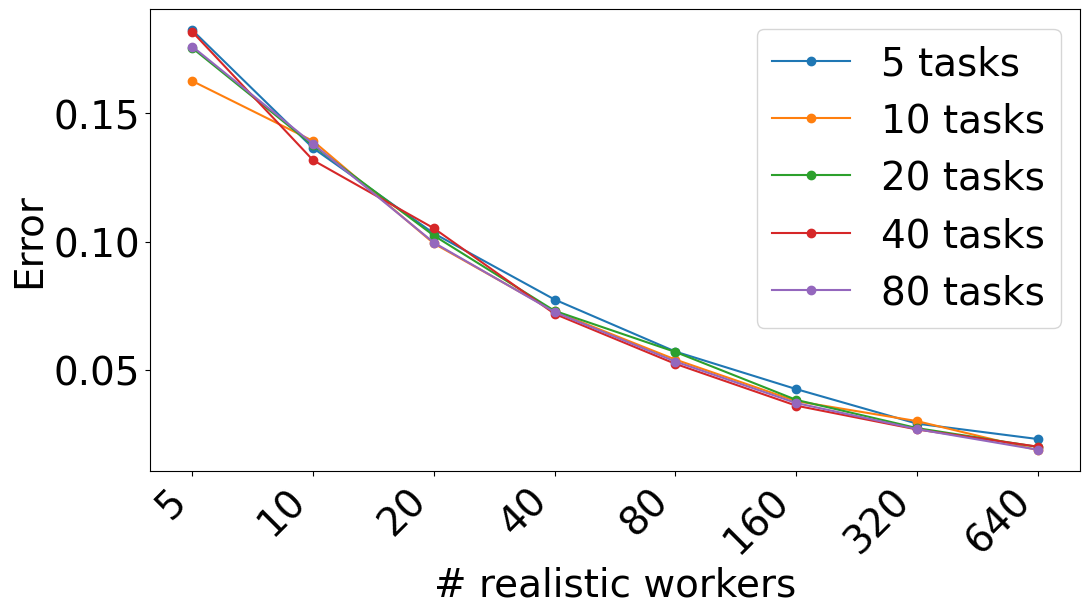

In [15]:
plot_experiment(final_errors, "# realistic workers", "Error", save_file=save_file)

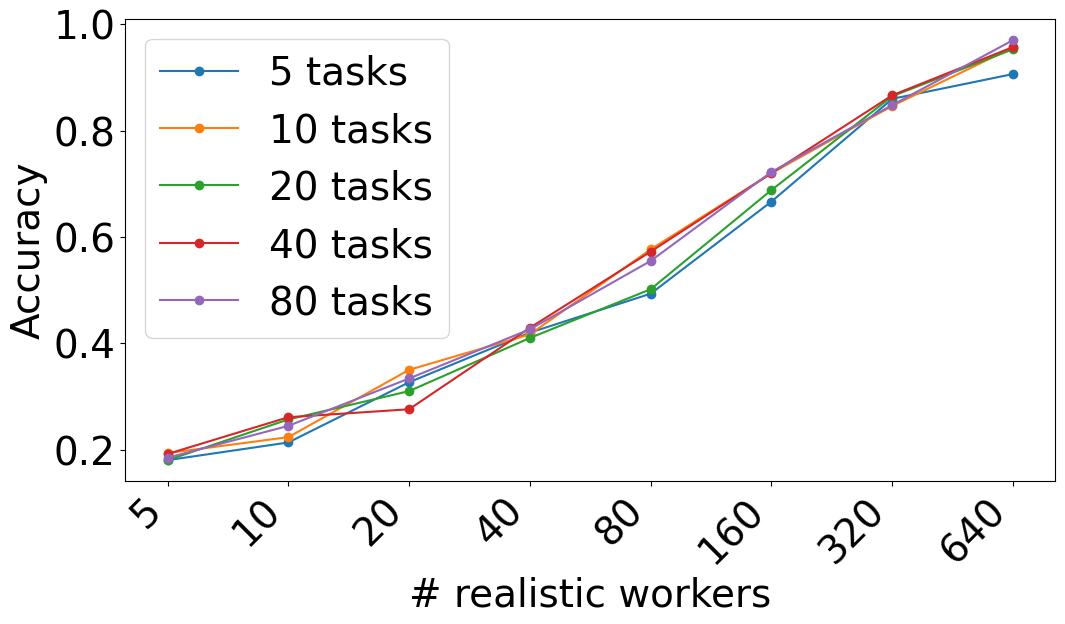

In [16]:
plot_experiment(final_accuracies, "# realistic workers", "Accuracy", save_file=save_file)